In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
    
class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()

        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))

        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))

    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1

        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)

        return m_hat / (torch.sqrt(v_hat) + self.eps)

    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta*2*Euv
        self.beta = self.beta + eta*2*Ev*Euv


class inc_BN(nn.Module):
    def __init__(self, layersize, eta=1):
        super(inc_BN, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            StDu = u.std()

        self.alpha = (1-eta)*self.alpha + eta * StDu
        self.beta = (1-eta)*self.beta + eta * Eu
        
#         self.eta = eta * 0.998
        
class og_IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(og_IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = self.alpha*x + self.beta
        
        return nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = self.alpha + eta * (1/self.alpha -2*Euv)
        self.beta = self.beta + eta * (-2*Ev)
        
#         self.eta = eta * 0.998


class Net(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(Net, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc3(v2))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        
        return o

class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = torch.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = torch.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = torch.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = torch.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = torch.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = torch.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = torch.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = torch.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = torch.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o
    
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = torch.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = torch.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = torch.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = torch.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = torch.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = torch.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = torch.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = torch.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = torch.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [3]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0

        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs, filename):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run %d" % (1))
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)

    #Train Incremental BN
    torch.manual_seed(seed)
    BNnet = DNet(LAYERSIZE, inc_BN, eta=int_lr)
    BNnet = BNnet.to(device)

    optimizer = optim.Adam(BNnet.parameters(), lr=syn_lr)
    print("Training Incremental BN. Run %d" % (1))
    bn_losses = train_deep_model(BNnet, optimizer, seed, epochs)
          
    #Train Deep OG IP
    torch.manual_seed(seed)
    DOGnet = DNet(LAYERSIZE, og_IP, eta=int_lr)
    DOGnet = DOGnet.to(device)

    optimizer = optim.Adam(DOGnet.parameters(), lr=syn_lr)
    print("Training Infomax Net. Run %d" % (1))
    og_losses = train_deep_model(DOGnet, optimizer, seed, epochs)
    
    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Incremental BN
        torch.manual_seed(seed)
        BNnet = DNet(LAYERSIZE, inc_BN, eta=int_lr)
        BNnet = BNnet.to(device)

        optimizer = optim.Adam(BNnet.parameters(), lr=syn_lr)
        print("Training Incremental BN. Run %d" % (i+2))
        bn_losses += train_deep_model(BNnet, optimizer, seed, epochs)
              
        #Train Deep OG IP
        torch.manual_seed(seed)
        DOGnet = DNet(LAYERSIZE, og_IP, eta=int_lr)
        DOGnet = DOGnet.to(device)

        optimizer = optim.Adam(DOGnet.parameters(), lr=syn_lr)
        print("Training Infomax Net. Run %d" % (i+2))
        og_losses += train_deep_model(DOGnet, optimizer, seed, epochs)
        
        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    bn_losses = bn_losses/test_runs
    og_losses = og_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(8, 8))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.plot(bn_losses[0], bn_losses[1], label="BN")
    plt.plot(og_losses[0], og_losses[1], label="Infomax")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(filename, dpi=300)
    plt.show()


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs, filename):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run %d" % (1))
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)

    #Train Incremental BN
    torch.manual_seed(seed)
    BNnet = CDNet(LAYERSIZE, inc_BN, eta=int_lr)
    BNnet = BNnet.to(device)

    optimizer = optim.Adam(BNnet.parameters(), lr=syn_lr)
    print("Training Incremental BN. Run %d" % (1))
    bn_losses = train_deep_model(BNnet, optimizer, seed, epochs)
          
    #Train Deep OG IP
    torch.manual_seed(seed)
    DOGnet = CDNet(LAYERSIZE, og_IP, eta=int_lr)
    DOGnet = DOGnet.to(device)

    optimizer = optim.Adam(DOGnet.parameters(), lr=syn_lr)
    print("Training Infomax Net. Run %d" % (1))
    og_losses = train_deep_model(DOGnet, optimizer, seed, epochs)
    
    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Incremental BN
        torch.manual_seed(seed)
        BNnet = CDNet(LAYERSIZE, inc_BN, eta=int_lr)
        BNnet = BNnet.to(device)

        optimizer = optim.Adam(BNnet.parameters(), lr=syn_lr)
        print("Training Incremental BN. Run %d" % (i+2))
        bn_losses += train_deep_model(BNnet, optimizer, seed, epochs)
              
        #Train Deep OG IP
        torch.manual_seed(seed)
        DOGnet = CDNet(LAYERSIZE, og_IP, eta=int_lr)
        DOGnet = DOGnet.to(device)

        optimizer = optim.Adam(DOGnet.parameters(), lr=syn_lr)
        print("Training Infomax Net. Run %d" % (i+2))
        og_losses += train_deep_model(DOGnet, optimizer, seed, epochs)
        
        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    bn_losses = bn_losses/test_runs
    og_losses = og_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(8, 8))
    plt.ylim([-0.1, 3])
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.plot(bn_losses[0], bn_losses[1], label="BN")
    plt.plot(og_losses[0], og_losses[1], label="Infomax")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(filename, dpi=300)
    plt.show()

# MNIST Test

In [4]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


Training IP Net. Run 1
[1] loss: 0.968
[2] loss: 0.432
[3] loss: 0.268
[4] loss: 0.207
[5] loss: 0.166
[6] loss: 0.141
[7] loss: 0.125
[8] loss: 0.111
[9] loss: 0.102
[10] loss: 0.094
[11] loss: 0.085
[12] loss: 0.087
[13] loss: 0.079
[14] loss: 0.072
[15] loss: 0.073
[16] loss: 0.066
[17] loss: 0.066
[18] loss: 0.059
[19] loss: 0.059
[20] loss: 0.054
Finished training!

Training Incremental BN. Run 1
[1] loss: 0.928
[2] loss: 0.518
[3] loss: 0.370
[4] loss: 0.270
[5] loss: 0.212
[6] loss: 0.184
[7] loss: 0.154
[8] loss: 0.140
[9] loss: 0.126
[10] loss: 0.114
[11] loss: 0.103
[12] loss: 0.096
[13] loss: 0.091
[14] loss: 0.084
[15] loss: 0.080
[16] loss: 0.073
[17] loss: 0.073
[18] loss: 0.066
[19] loss: 0.066
[20] loss: 0.056
Finished training!

Training Infomax Net. Run 1
[1] loss: 0.966
[2] loss: 0.468
[3] loss: 0.273
[4] loss: 0.204
[5] loss: 0.171
[6] loss: 0.158
[7] loss: 0.148
[8] loss: 0.139
[9] loss: 0.128
[10] loss: 0.119
[11] loss: 0.118
[12] loss: 0.114
[13] loss: 0.107
[14]

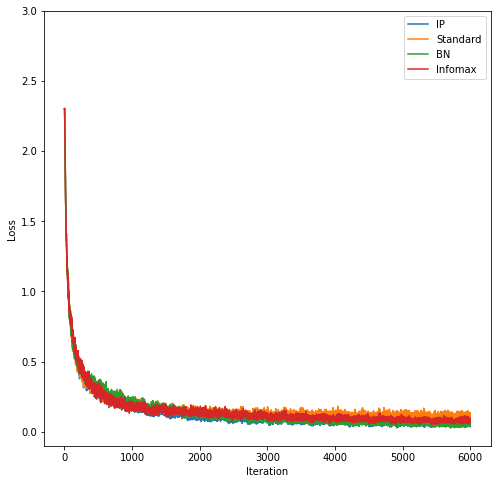

In [5]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 20

test_runs = 10

int_lr = 0.0001
syn_lr = 0.005

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs, '../images/compare1.png')

# CIFAR-10 Test

In [6]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Training IP Net. Run 1
[1] loss: 2.052
[2] loss: 1.891
[3] loss: 1.823
[4] loss: 1.772
[5] loss: 1.728
[6] loss: 1.682
[7] loss: 1.641
[8] loss: 1.619
[9] loss: 1.571
[10] loss: 1.536
[11] loss: 1.531
[12] loss: 1.491
[13] loss: 1.463
[14] loss: 1.453
[15] loss: 1.418
[16] loss: 1.399
[17] loss: 1.375
[18] loss: 1.358
[19] loss: 1.342
[20] loss: 1.319
[21] loss: 1.313
[22] loss: 1.289
[23] loss: 1.272
[24] loss: 1.272
[25] loss: 1.247
[26] loss: 1.242
[27] loss: 1.220
[28] loss: 1.214
[29] loss: 1.196
[30] loss: 1.187
[31] loss: 1.177
[32] loss: 1.169
[33] loss: 1.160
[34] loss: 1.142
[35] loss: 1.125
[36] loss: 1.122
[37] loss: 1.124
[38] loss: 1.105
[39] loss: 1.090
[40] loss: 1.100
Finished training!

Training Incremental BN. Run 1
[1] loss: 2.053
[2] loss: 1.877
[3] loss: 1.814
[4] loss: 1.757
[5] loss: 1.706
[6] loss: 1.674
[7] loss: 1.638
[8] loss: 1.622
[9] loss: 1.590
[10] loss: 1.561
[11] loss: 1.553
[12] loss: 1.513
[13] loss: 1.488
[14] loss: 1.472
[15] loss: 1.453
[16] loss

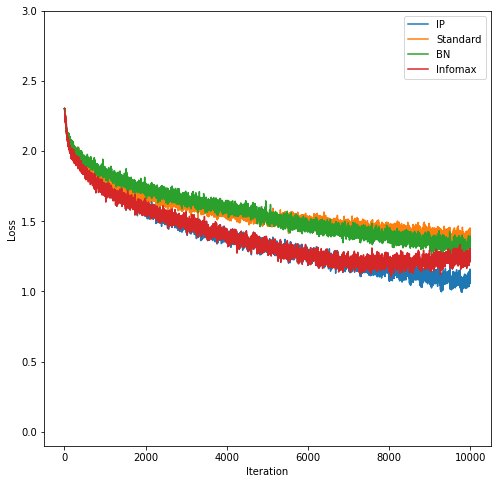

In [7]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.0001
syn_lr = 0.001

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs, '../images/compare2.png')